In [2]:
import numpy as np
from pathlib import Path
import cv2
import pandas as pd
from skimage import measure, filters, draw
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tqdm 
from scipy import ndimage

import SimpleITK as sitk
import itkwidgets 
import napari
import copy

from napari.utils.colormaps import colormap_utils as cu

In [3]:
def find_slice_with_mask(mask):
    '''
    Détecte sur les index des premières et dernière tranches d'un masque. 
    Args:
        mask (np array): le masque ou le fond est des 1 et le masque des 0
    Return:
        (rangemin,rangemax) (int,int): tuple avec l'index des premières et dernière tranches d'un masque. 
    '''
    nb_slices_with_masks=[]
    for nb_slice in range(mask.shape[0]-1, 0,-1):
        if 255 in mask[nb_slice]:
            nb_slices_with_masks.append(nb_slice)
    rangemin = np.min(nb_slices_with_masks) #mask 1
    rangemax = np.max(nb_slices_with_masks) #mask 1
    return (rangemin,rangemax)

In [4]:
def fit_ellipses(mask, rangemin, rangemax):
    ''' 
    Le but est de récuperer les paramètres d'une liste ellipse en fonction d'une liste de masques fournis par le network construction
    Args :
        mask (numpy array) : masque des artères
        rangemin (int): début des coupes sélectionnées
        rangemax (int): fin des coupes sélectionnées
    Return:
        list_params_ellipses_to_return (list[list[double]]): paramètres de chaque ellipse
    '''
    list_params_ellipses=[]
    for index_img in tqdm.tqdm(reversed(range(rangemax-rangemin))):
        img=mask[rangemin+index_img]
        contours_found,_=cv2.findContours(img.astype(np.uint8), method=cv2.RETR_LIST, mode=cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_found)>0: ## attention à remodifier
            if len(contours_found[0])>5:
                ellipse=cv2.fitEllipse(contours_found[0])
                ellipse_ok=((ellipse[0][0], ellipse[0][1]), (ellipse[1][0]/2,ellipse[1][1]/2), ellipse[2])
                # print(ellipse_ok)
                list_params_ellipses.append(ellipse_ok)
            else:
                ellipse_ok=((list_params_ellipses[-1][0][0], list_params_ellipses[-1][0][1]), (list_params_ellipses[-1][1][0]/2,ellipse[1][1]/2), list_params_ellipses[-1][2])
                list_params_ellipses.append(ellipse_ok)
        else:
            print("erreur nb contours")
            
    list_params_ellipses.reverse()
    return list_params_ellipses

In [5]:
def predict_and_compare_values(list_params):
    #working on it
    new_list_params=[list_params[-1]]
    list_products = [my_tuple[1][0]*my_tuple[1][1] for my_tuple in list_params]
    list_indexes= [ i for i in range(len(list_products))]
    fit = np.polyfit(list_indexes, list_products, deg=1)
    predict_size_area = np.poly1d(fit)
    list_products_predicted=[predict_size_area(index) for index in list_indexes]
    
    count=0
    for index in reversed(range(len(list_products_predicted)-1)):
        product_predicted=list_products_predicted[index]
        if np.abs((product_predicted-list_products[index])*100/product_predicted)<50: #si moins de 10 pourcent d'erreurs, je garde ma value originales
            new_list_params.append(list_params[index])
        else: #sinon, je mets les param de l'ellipse précédente
            new_list_params.append(new_list_params[-1])
            count+=1
    # print("count ",count)
    new_list_params.reverse()
    return new_list_params

In [6]:
def dilation(img_3D, kernel_size):
    ''' 
    Dilatation d'une image 
    Args:
        img_3D (numpy array): image à dilater
        kernel_size (int): taille du kernel
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
    for index, slice in enumerate(img_3D):
        img_3D[index] = cv2.dilate(img_3D[index] , kernel, iterations=1)

In [7]:
def create_3d_ellipses(list_params_ellipses, shape_image, rangemin, rangemax, dilate=False):
    ''' 
    Draw 3d ellipses on a white image
    Args:
        list_params_ellipses (list[list[double]]): the parameters of each ellipse
        mask (numpy array): the initial masks
        rangemin (int): first slice of the mask
        rangemask (int): last slice of the mask
        dilate (Boolean): indicatinf if neede to dliate of not the image
    Return:
        ellipses_3d (numpy array): images with drawing of ellipses on it
    '''
    ellipses_3d = []
    for index_img in tqdm.tqdm(range(rangemax-rangemin)):
        ellipse_mask = np.zeros((shape_image[1],shape_image[2]), dtype=np.uint8)
        params = list_params_ellipses[index_img]
        center = (int(params[0][0]),int(params[0][1]))
        axis = (int(params[1][0]),int(params[1][1]))
        angle = int(params[2])
        color = 255
        cv2.ellipse(ellipse_mask, center, axis, angle, 0, 360, color,-1)
        ellipses_3d.append(ellipse_mask)
    numpy_ellipse_3d=np.array(ellipses_3d)
    if dilate:
        dilation(numpy_ellipse_3d, kernel_size=4)
    return numpy_ellipse_3d

In [8]:
def keeping_arteries_only(filled_ellipses, image):
    '''
    Le but est de garder l'image originale en la restreignant à l'intérieur des ellipses.
    Args:
        filled_ellipses (np.array): les ellipses remplies
        image (np.array): image d'origine 
    Return:
        list_arteries_only (np.array): l'image originale restreinte à l'intérieur des ellipses
    ''' 
    list_arteries_only=np.where(filled_ellipses==255, image, 0)
    return list_arteries_only

In [9]:
def construct_ellipses_network(mask):
    #working on it 
    '''
    En partant de la liste de masques construite par la network construction, des ellipses sont approximées pour reconstruire un réseau artériel lisse. 
    Args:
        mask_list (list[np.array]): la liste des masque construite par la network construction
    Return:
        info_all_masks (list[dic]): une liste où pour chaque loigne (qui correspond à un masque), il y a un dictionnaire où les clefs sont: rangemin, rangemax, mask,  smooth_ellipses
        ellipses_network (np.array): l'image 3D où le réseau d'ellipse est reconstitué
    ''' 
    rangemin,rangemax=find_slice_with_mask(mask)
    list_params=fit_ellipses(mask, rangemin, rangemax)
    # ellipses_3d=create_3d_ellipses(list_params,mask.shape, rangemin, rangemax)
       
    new_list_param=predict_and_compare_values(list_params)
    new_ellipses_3d=create_3d_ellipses(new_list_param,mask.shape, rangemin, rangemax, dilate=True)

    before=np.zeros((rangemin, mask.shape[1],mask.shape[1]))
    after=np.zeros((mask.shape[0]-rangemax, mask.shape[1],mask.shape[1]))
    whole_size_ellipses_3D=np.concatenate((before,new_ellipses_3d,after))

    info_of_one_mask={'rangemin':rangemin,'rangemax':rangemax,'mask':mask, 'ellipses_3D':whole_size_ellipses_3D}
    return info_of_one_mask

In [10]:
def construct_mask_network(mask_list,range_to_do):
    '''
 
    ''' 
    mask_network=np.zeros(mask_list[0].shape)
    for index_mask in tqdm.tqdm(range(range_to_do)):#len(mask_list))):
        mask_ok=np.where(mask_list[index_mask]==255,0,1)
        
        mask_network=mask_network+mask_ok
        mask_network_ok=np.where(mask_network>1,1,mask_network)
    return mask_network_ok

# constructing the whole network

In [10]:
import gzip

f = gzip.GzipFile('temp/mask_list.npy.gz', "r")
mask_list = np.load(f)


# image_original = sitk.ReadImage(Path("data/anonymise_patient1.mhd"))
# reshapeFilter = sitk.IntensityWindowingImageFilter()
# reshapeFilter.SetWindowMinimum(0)
# reshapeFilter.SetWindowMaximum(1000)
# reshapeFilter.SetOutputMinimum(0)
# reshapeFilter.SetOutputMaximum(255)
# resultReshape = reshapeFilter.Execute(image_original)
#image_array_original = sitk.GetArrayFromImage(resultReshape)

image_original = np.load(Path("temp/preprocessed_image.npy"))

print(mask_list.shape)

(13, 1532, 512, 512)


to plot everything on the same graph

In [15]:
min_range=0
max_range=1#len(mask_list)
info_one_mask={}
ellipses_network=np.zeros_like(mask_list[0])#, dtype=np.uint8)
arteries_network=np.zeros_like(mask_list[0])#, dtype=np.uint8)
reconstruct_or_not=False
for index in range(min_range,max_range):
    print(index+1-min_range, " out of ", max_range-min_range)
    info_one_mask= construct_ellipses_network(mask_list[index])
    if reconstruct_or_not:
        ellipses_network=ellipses_network+info_one_mask['ellipses_3D']
        ellipses_network_ok=np.where(ellipses_network>255,255,ellipses_network)
    arteries_whole=keeping_arteries_only(info_one_mask['ellipses_3D'], image_original)
    rangemin=info_one_mask['rangemin']
    rangemax=info_one_mask['rangemax']
    arteries_min_max=keeping_arteries_only(info_one_mask['ellipses_3D'][rangemin:rangemax], image_original[rangemin:rangemax])
    # np.save(Path("temp/arteries"+str(index)+".npy"), arteries_min_max)
    print(arteries_min_max.shape)
    # np.save(Path("temp/ellipses"+str(index)+".npy"), info_one_mask['ellipses_3D'][rangemin:rangemax])
    print(info_one_mask['ellipses_3D'][rangemin:rangemax].shape)
    #here we do the stats, within a function
    if reconstruct_or_not:
        arteries_network=arteries_network+arteries_whole
        arteries_network=np.where(arteries_network>255,arteries_network/2,arteries_network)  

1  out of  2


265it [00:00, 3209.85it/s]
100%|██████████| 265/265 [00:00<00:00, 7424.49it/s]


(265, 512, 512)
(265, 512, 512)
2  out of  2


230it [00:00, 2533.42it/s]
100%|██████████| 230/230 [00:00<00:00, 5849.23it/s]


(230, 512, 512)
(230, 512, 512)


In [12]:
viewer = napari.Viewer()
image_layer = viewer.add_image(arteries_network, colormap="gray", contrast_limits=(0,255))
image_layer = viewer.add_image(ellipses_network, colormap="blue", contrast_limits=(0,255), blending="additive")
napari.run()

on one mask only

In [28]:
# mask = mask_list[0]
# rangemin,rangemax=find_slice_with_mask(mask)
# arteries=keeping_arteries_only(new_ellipses3D, image_array[rangemin:rangemax])

# viewer = napari.Viewer()
# image_layer = viewer.add_image(arteries, colormap="gray", contrast_limits=(0,255))
# napari.run()

# Partie stats

In [12]:
# np.save(Path("temp/arteries.npy"), arteries)
# np.save(Path("temp/ellipses.npy"), new_ellipses3D)
arteries = np.load(Path("temp/arteries_min_max.npy"))
ellipses3D = np.load(Path("temp/ellipses.npy"))

Récupérer une liste de valeurs de pixels par slice, en prenant en compte uniquement les pixels dans l'ellipse

In [59]:
arteries_only = np.where(ellipses3D == 255, arteries, np.nan)
arteries_only_flatten = arteries_only.reshape(arteries_only.shape[0], arteries_only.shape[1]*arteries_only.shape[2])
list_values=[]
for slice in arteries_only_flatten:
    slice = list(slice[np.logical_not(np.isnan(slice))]) # remove nan
    list_values.append(slice)

In [15]:
# a modifier pour avoir une classe calcification avec la slice, le pourcentage et le masque de calcification

def find_calcifications (pixel_values, pourcentage):
    ''' 
    Fonction pour trouver les calcifications les plus importantes de chaque masque
    Args:
        pixel_values (list[list[double]]) : valeurs des pixels dans chacune des coupes de l'image
        pourcentage (int) : le pourcentage de calcifications qu'on veut retourner 
    Return:
        list_calcifications (list[int, double]) : retourne un tuple avec l'index de la coupe et son pourcentage de calcification
    '''
    # calcul pourcentage de calcification
    proportion_calcification = []
    for slice in pixel_values:
        nb_pixel_250 = sum(1 for valeur in slice if valeur > 250)
        proportion = nb_pixel_250 / len(slice)
        proportion_calcification.append(proportion)

    # sélectionner les n plus grosses calcifications
    n = int(pourcentage/100 * len(list_values))
    sorted_indices = np.argsort(proportion_calcification)[::-1] #trier indices par ordre décroissant
    top_n_indices = sorted_indices[:n]
    list_calcifications = [(i, proportion_calcification[i]) for i in top_n_indices]

    return list_calcifications

In [24]:
def remove_calcifications(pixel_values):
    for i in range(len(pixel_values)):
        pixel_values[i] = [valeur for valeur in list_values[i] if valeur < 250]

In [16]:
print(find_calcifications(list_values, 5))

[(71, 0.2643171806167401), (72, 0.24675324675324675), (73, 0.2412280701754386), (70, 0.24034334763948498), (69, 0.23555555555555555), (67, 0.22317596566523606), (68, 0.20851063829787234), (66, 0.20306513409961685), (74, 0.19736842105263158), (75, 0.16176470588235295), (80, 0.15196078431372548), (144, 0.1488673139158576), (76, 0.14761904761904762), (145, 0.1465798045602606), (65, 0.1417624521072797), (146, 0.14012738853503184), (77, 0.1391304347826087), (82, 0.13736263736263737), (150, 0.13119533527696792), (149, 0.13099041533546327)]


In [25]:
remove_calcifications(list_values)

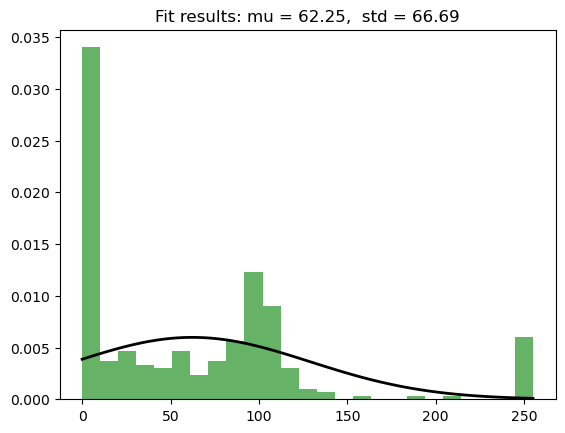

In [66]:
# fit a normal distribution on the points on each slice
from scipy.stats import norm

my_slice = list_values[120]

# fit a normal distribution
mu, std = norm.fit(my_slice)
plt.hist(my_slice, bins=25, density=True, alpha=0.6, color='g')

# Plot
xmin = 0
xmax = 255
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

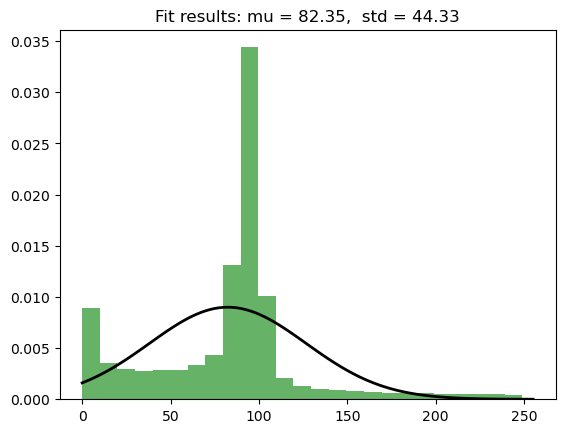

In [45]:
# créer une distribution de référence : en utilisant tous les points ?

# fit a normal distribution
list_values_flatten = [element for sublist in list_values for element in sublist]
mu0, std0 = norm.fit(list_values_flatten)
plt.hist(list_values_flatten, bins=25, density=True, alpha=0.6, color='g')

# Plot
xmin = 0
xmax = 255
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

Kolmogorov-Smirnov test : tester si deux échantillons suivent la même loi

In [68]:
from scipy import stats
list_pvalues = []
list_stats_test = []

for slice in list_values:
    a = stats.ks_2samp(slice, list_values_flatten)
    list_stats_test.append(a[0])
    list_pvalues.append(a[1])

# for index, pvalue in enumerate(res):
#     if pvalue > 0.05:
#         print(index)

In [70]:
for index, pvalue in enumerate(res):
    if pvalue > 0.05:
        print(index)

61
62
96
105
106
151
157
173
231
237
242
244
253
254
255
258
259
263
269
270
372


In [71]:
viewer = napari.Viewer()
image_layer = viewer.add_image(arteries, colormap="gray", contrast_limits=(0,255))
napari.run()